# Lyric Predictor 

This project stemmed from the song 'Old Town Road' being removed from Billboard Hot Country charts. 
https://www.cbsnews.com/news/old-town-road-lil-nas-x-billboard-removes-song-from-hot-country-critics-question-race-factor/

Billboard removed the song because it "does not embrace enough elements of today's country music to chart in its current version." This led to a rise in popularity, remixes, and inspiration for this project. 

Can machine learning be used to classify songs based on their lyrics?


## Import Needed Modules

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


### I created a spreadsheet with 30 top hip hop and 30 top country songs from the week of 6/29/2019
https://www.billboard.com/charts/country-songs/2019-06-29

https://www.billboard.com/charts/country-songs/2019-06-29

In [2]:
df1 = pd.read_csv(r"C:\Users\LG\Downloads\datasci\music genre\lyrics.csv",encoding='latin-1')

In [3]:
df1.sample(5)

,Text,Genre,Title,Author
47,"I would give you the world, nah, nah, nah\nYou...",Hip-Hop,Worth IT,YK Osiris
3,I've had a largemouth bass bust my line\nA cou...,Country,Beer Never Broke My Heart,Luke Combs
11,"Yeah, okay\n'Lil CC, on the beat, hm\nYeah, ye...",Hip-Hop,Money in the Grave,Drake
58,"Tell 'em, slime\nYeah, I am the king of the E....",Hip-Hop,Down Bad,"Dreamville Featuring JID, Bas, J. Cole, EARTHG..."
2,Girl you know I've known you forever\nHow many...,Country,Rumor,Lee Brice


### Split the dataframe into respective genres to get character counts and generate wordclounds 

In [4]:
country = df1[(df1['Genre']=='Country')]
hiphop = df1[(df1['Genre']=='Hip-Hop')]

In [5]:
country['Text'].head()

0    Right outside of this one church town\nThere's...
1    Pour me, pour me another drink\nCause I don't ...
2    Girl you know I've known you forever\nHow many...
3    I've had a largemouth bass bust my line\nA cou...
4    Don't even want the attention\nBut yeah, that'...
Name: Text, dtype: object

In [46]:
country_text = " ".join(review for review in country['Text'])
print ("There are {} character avg per song in country lyrics.".format((len(country_text))/len(country['Text'])))
hiphop_text = " ".join(review for review in hiphop['Text'])
print ("There are {} character avg per song in hiphop lyrics.".format((len(hiphop_text))/len(hiphop['Text'])))

There are 1635.4 character avg per song in country lyrics.
There are 2794.1666666666665 character avg per song in hiphop lyrics.


In [7]:
country_wordcloud = WordCloud(background_color="white").generate(country_text)
hiphop_wordcloud = WordCloud(background_color="white").generate(hiphop_text)

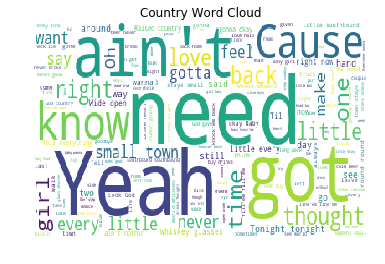

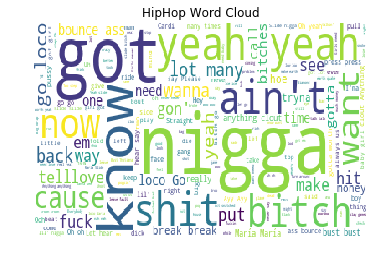

In [8]:
plt.imshow(country_wordcloud,aspect='auto')
plt.axis("off")
plt.title('Country Word Cloud')
plt.show()
plt.imshow(hiphop_wordcloud,aspect='auto')
plt.axis("off")
plt.title('HipHop Word Cloud')
plt.show()

### Update Stop Words

In [9]:
stop_words = ["got", "cause", "lot", "put", "want", "yeah", "one", "way"] + list(STOPWORDS)

In [10]:
country_wordcloud = WordCloud(stopwords = stop_words, background_color="white",max_words=30).generate(country_text)
hiphop_wordcloud = WordCloud(stopwords = stop_words, background_color="white",max_words=30).generate(hiphop_text)

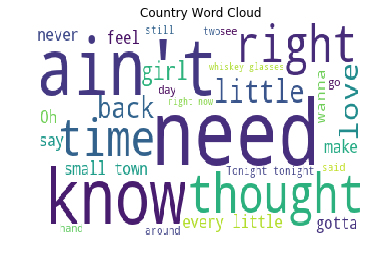

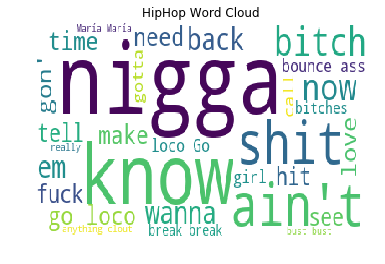

In [11]:
plt.imshow(country_wordcloud,aspect='auto')
plt.axis("off")
plt.title('Country Word Cloud')
plt.show()
plt.imshow(hiphop_wordcloud,aspect='auto')
plt.axis("off")
plt.title('HipHop Word Cloud')
plt.show()

### Start Processing Data using Natural Language Toolkit (nltk)

start by making all words lower case, breakup works into usable pieces (tokenize), and create new column for lemmatization (reducing words to their root) 

In [12]:
df1['Text'] = [entry.lower() for entry in df1['Text']]

In [13]:
df1.head()

,Text,Genre,Title,Author
0,right outside of this one church town\nthere's...,Country,God's country,Blake Shelton
1,"pour me, pour me another drink\ncause i don't ...",Country,Whiskey Glasses,Morgan Wallen
2,girl you know i've known you forever\nhow many...,Country,Rumor,Lee Brice
3,i've had a largemouth bass bust my line\na cou...,Country,Beer Never Broke My Heart,Luke Combs
4,"don't even want the attention\nbut yeah, that'...",Country,Look What God Gave Her,Thomas Rhett


In [14]:
import nltk
nltk.download('punkt')
df1['Text']= [word_tokenize(entry) for entry in df1['Text']]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
df1.head()

,Text,Genre,Title,Author
0,"[right, outside, of, this, one, church, town, ...",Country,God's country,Blake Shelton
1,"[pour, me, ,, pour, me, another, drink, cause,...",Country,Whiskey Glasses,Morgan Wallen
2,"[girl, you, know, i, 've, known, you, forever,...",Country,Rumor,Lee Brice
3,"[i, 've, had, a, largemouth, bass, bust, my, l...",Country,Beer Never Broke My Heart,Luke Combs
4,"[do, n't, even, want, the, attention, but, yea...",Country,Look What God Gave Her,Thomas Rhett


In [16]:
nltk.download('wordnet')
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
df1.head()

,Text,Genre,Title,Author
0,"[right, outside, of, this, one, church, town, ...",Country,God's country,Blake Shelton
1,"[pour, me, ,, pour, me, another, drink, cause,...",Country,Whiskey Glasses,Morgan Wallen
2,"[girl, you, know, i, 've, known, you, forever,...",Country,Rumor,Lee Brice
3,"[i, 've, had, a, largemouth, bass, bust, my, l...",Country,Beer Never Broke My Heart,Luke Combs
4,"[do, n't, even, want, the, attention, but, yea...",Country,Look What God Gave Her,Thomas Rhett


In [18]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
for index,entry in enumerate(df1['Text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df1.loc[index,'text_final'] = str(Final_words)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Train Data

Machine Learning algorithms do better with numbers so we need to vectorize (turn words to numerical features) and encode our target data (genre)

In [19]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df1['text_final'],df1['Genre'],test_size=0.3, random_state = 42)

In [20]:
print(Test_Y)

0     Country
5     Country
36    Country
45    Hip-Hop
13    Hip-Hop
54    Hip-Hop
33    Country
48    Hip-Hop
12    Hip-Hop
57    Hip-Hop
46    Hip-Hop
50    Hip-Hop
31    Country
3     Country
52    Hip-Hop
17    Hip-Hop
8     Country
6     Country
Name: Genre, dtype: object


In [21]:
print(Train_X)

40    ['real', 'as', 'bitch', 'give', 'fuck', 'nigga...
4     ['even', 'want', 'attention', 'yeah', 'get', '...
43    ['real', 'real', 'time', 'real', 'real', 'real...
19    ['good', 'niggas', 'countin', 'countin', 'bull...
34    ['whiskey', 'gasoline', 'light', 'fire', 'burn...
58    ['tell', 'slime', 'yeah', 'king', 'get', 'bitc...
25    ['know', 'never', 'come', 'spot', 'thursday', ...
56    ['tay', 'keith', 'fuck', 'nigga', 'make', 'hap...
15    ['ayy', 'ayy', 'ayy', 'ayy', 'ooh', 'ooh', 'oo...
27    ['still', 'get', 'number', 'phone', 'even', 't...
9     ['beer', 'keep', 'love', 'cheap', 'truck', 'wr...
30    ['ca', 'go', 'ride', 'clear', 'head', 'everyth...
26    ['suppose', 'hurt', 'broken', 'heart', 'moving...
16    ['men', 'great', 'get', 'ta', 'great', 'woo', ...
24    ['tour', 'middle', 'june', 'plan', 'welcome', ...
55    ['wish', 'everything', 'touch', 'would', 'turn...
11    ['yeah', 'okay', 'cc', 'beat', 'hm', 'yeah', '...
32    ['baby', 'alabama', 'dixie', 'land', 'deli

In [22]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [23]:
print(Test_Y)

[0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0]


In [24]:
print("Country: 0, Hiphop: 1")

Country: 0, Hiphop: 1


In [25]:
Tfidf_vect = TfidfVectorizer(max_features=1000)
Tfidf_vect.fit(df1['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [26]:
print(Tfidf_vect.vocabulary_)

{'right': 699, 'outside': 593, 'one': 588, 'town': 894, 'gold': 349, 'dirt': 235, 'road': 705, 'whole': 959, 'lot': 489, 'nothing': 578, 'get': 334, 'land': 438, 'ai': 7, 'ground': 358, 'god': 347, 'country': 195, 'pray': 643, 'rain': 670, 'bring': 119, 'little': 471, 'bit': 81, 'money': 535, 'put': 660, 'back': 41, 'guess': 360, 'call': 142, 'saw': 728, 'light': 459, 'sunrise': 837, 'sittin': 772, 'muddy': 545, 'river': 704, 'side': 762, 'gettin': 335, 'baptize': 50, 'holy': 398, 'water': 937, 'shine': 747, 'dog': 243, 'save': 727, 'sound': 803, 'find': 297, 'dixie': 237, 'whistle': 956, 'wind': 967, 'heaven': 383, 'bind': 77, 'devil': 227, 'go': 345, 'georgia': 333, 'stick': 820, 'around': 30, 'turn': 908, 'work': 976, 'week': 944, 'do': 241, 'take': 849, 'break': 115, 'bread': 114, 'sunday': 835, 'proud': 655, 'yeah': 992, 'care': 150, 'read': 678, 'kind': 430, 'box': 110, 'end': 267, 'time': 883, 'lay': 443, 'foot': 313, 'deep': 225, 'pour': 639, 'another': 21, 'drink': 252, 'cause

### Use Naive Bayes Classifier to make predictions

In [28]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(Test_Y,predictions_NB)*100)

Naive Bayes Accuracy Score ->  83.33333333333334


In [29]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(Test_Y,predictions_NB))  
print(classification_report(Test_Y,predictions_NB))


[[7 1]
 [2 8]]
             precision    recall  f1-score   support

          0       0.78      0.88      0.82         8
          1       0.89      0.80      0.84        10

avg / total       0.84      0.83      0.83        18



### Webscraping target lyric into new data set. I chose old town road and fresh prince theme song

In [30]:
import requests
from bs4 import BeautifulSoup, NavigableString
import re


In [31]:
url = 'http://www.metrolyrics.com/fresh-prince-of-bel-air-lyrics-will-smith.html'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')
lyrics = soup.find_all('p',{"class": "verse"})
song1 = ''
for verse in lyrics:
    song1 = song1 + verse.get_text()

In [32]:
url = 'http://www.metrolyrics.com/old-town-road-lyrics-lil-nas-x.html'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')
lyrics = soup.find_all('p',{"class": "verse"})
song2 = ''
for verse in lyrics:
    song2 = song2 + verse.get_text()
print(song2)

Yeah, I'm gonna take my horseTo the old town road
I'm gonna ride till I can't no more
I'm gonna take my horse to the old town road
I'm gonna ride till I can't no more
Kio, KioI got the horses in the back
Horse tack is attached
Hat is matte black
Got the boots that's black to match
Ridin' on a horse, ha
You can whip your Porsche
I been in the valley
You ain't been up off the porch, nowCan't nobody tell me nothin'
You can't tell me nothin'
Can't nobody tell me nothin'
You can't tell me nothin'Ridin' on a tractor
Lean all in my bladder
Cheated on my baby
You can go and ask her
My life is a movie
Bull ridin' and boobies
Cowboy hat from Gucci
Wrangler on my bootyCan't nobody tell me nothin'
You can't tell me nothin'
Can't nobody tell me nothin'
You can't tell me nothin'Yeah, I'm gonna take my horse
To the old town road
I'm gonna ride till I can't no more
I'm gonna take my horse to the old town road
I'm gonna ride till I can't no more
I got the


In [33]:
type(song1)

str

In [34]:
d = {'Text': [song1, song2], 'Genre': ['NA','NA'],'Title':['Fresh Prince of Bel-Air','Old Town Road'],'Author':['Will Smith','Lil Nas X']}
df2 = pd.DataFrame(data=d)

In [35]:
df2.head()

,Text,Genre,Title,Author
0,"Now, this is a story all about how\nMy life go...",NA,Fresh Prince of Bel-Air,Will Smith
1,"Yeah, I'm gonna take my horseTo the old town r...",NA,Old Town Road,Lil Nas X


### Follow the same process as above to prep data to feed into predictor

In [36]:
df2['Text']= [word_tokenize(entry) for entry in df2['Text']]

In [37]:
df2.head()

,Text,Genre,Title,Author
0,"[Now, ,, this, is, a, story, all, about, how, ...",NA,Fresh Prince of Bel-Air,Will Smith
1,"[Yeah, ,, I, 'm, gon, na, take, my, horseTo, t...",NA,Old Town Road,Lil Nas X


In [38]:
for index,entry in enumerate(df2['Text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df2.loc[index,'text_final'] = str(Final_words)

In [39]:
df2['text_final']

0    ['Now', 'story', 'My', 'life', 'get', 'upside'...
1    ['Yeah', 'I', 'gon', 'na', 'take', 'horseTo', ...
Name: text_final, dtype: object

In [40]:
Guess_X_Tfidf = Tfidf_vect.transform(df2['text_final'])


In [41]:
print(Naive.predict(Guess_X_Tfidf))

[0 0]


### Classifier predicts country for both lyrics. 

Ways to imporve this woudl be a much larger n. I selected only 30 songs from each genre at a specific point in time. Using additional algorithms SVM?

### Resources

https://aiiseasy.com/2019/06/09/text-classification-svm-naive-bayes-python/

https://www.datacamp.com/community/tutorials/wordcloud-python